# Project to Build a Model for Housing Prices.

## Milestone 1

$\;\;\;\;\;\;$ While working in the mortgage sector there tends to be quite a few customers that will say their home is worth more than what the appraiser has indicated. A small mortgage company in Texas seems to be getting many customer complaints about the values of their homes that appraisers are providing. The mortgage company decided that they want to have a model created for homes that are currently listed for sale to use to determine if the appraisers are providing appropriate values for homes. The model will take in some characteristics of a home such as bedrooms, bathrooms, square footage, and age of the home to aid in predicting what a specific home should sell for. The data set for this project can be found on the following link (https://www.kaggle.com/datasets/kanchana1990/texas-real-estate-trends-2024-500-listings/code). 

$\;\;\;\;\;\;$ The data contains a mix of values and categories that can be used for the analysis. However, there are a couple of columns that will provide no insight to the model. The columns that provide no value to the model will be removed. Once the model is complete the mortgage company will be able to input characteristics of customer’s homes into the model to predict what the value of the home should be. This will aid in the mortgage companies' decision to either ignore what value the appraiser has provided for the home as a work around or support what they are providing as the value. Using this to help keep records of home values will also allow the mortgage company to track the performance of the appraisers that they are employing. The main characteristics of a home will be the primary focus of the project. However, since property descriptions are provided, an additional model will be created to see if this affects the listing price for a home. By the project's end, we will have at least two models in which the mortgage or real-estate sector can use to predict home values.

In [1]:
import pandas as pd
import numpy as np
import string
import nltk

from sklearn.preprocessing import PowerTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewpfeifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [3]:
def remove_stop(x):
    return [word for word in x if word not in stop_words]

In [4]:
def stemmer(tokenized):
    text = [porter.stem(word) for word in tokenized]
    return text

### Exploring The Data

In [5]:
# Import the data and check that it loaded in properly.

housing = pd.read_csv('real_estate_texas_500_2024.csv')
housing.head()

,url,status,id,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,sub_type,text,type,year_built
0,https://www.realtor.com/realestateandhomes-det...,for_sale,9773941616,240000.0,2,2.0,2.0,3.0,1190.0,1.0,NaN,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,https://www.realtor.com/realestateandhomes-det...,for_sale,9224923922,379900.0,4,3.0,3.0,4.0,2033.0,1.0,NaN,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,https://www.realtor.com/realestateandhomes-det...,for_sale,9840661824,370000.0,2,2.0,2.0,4.0,2062.0,1.0,NaN,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,https://www.realtor.com/realestateandhomes-det...,for_sale,7338317229,444000.0,4,3.0,3.0,5.0,3705.0,2.0,NaN,Come check out country living in the city! Are...,single_family,1985.0
4,https://www.realtor.com/realestateandhomes-det...,for_sale,7285845528,569000.0,2,2.0,2.0,3.0,3282.0,2.0,NaN,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


In [6]:
# Check the dimensions of the data set.

housing.shape

(501, 14)

In [7]:
# Check the data types of the data frame columns.

housing.dtypes

url                 object
status              object
id                   int64
listPrice          float64
baths                int64
baths_full         float64
baths_full_calc    float64
beds               float64
sqft               float64
stories            float64
sub_type            object
text                object
type                object
year_built         float64
dtype: object

In [8]:
# Checking what information is in the sub_type column.

housing['sub_type'].unique()

array([nan, 'townhouse', 'condo'], dtype=object)

In [9]:
# Checking what information is in the status column.

housing['status'].unique()

array(['for_sale'], dtype=object)

The data set has 14 cloumns and 501 rows. The data set includes a mix of floats integers and object types. The status column provides nothing valuable to the model and sub_type seems to be the same information as type. Both should be considered for removal.

In [10]:
# Obtain the describe statistics from the data set

housing.describe()

,id,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,year_built
count,5.010000e+02,4.990000e+02,501.000000,436.000000,436.000000,440.000000,438.000000,391.000000,289.000000
mean,9.193045e+09,5.106686e+05,2.323353,2.332569,2.332569,3.454545,2334.568493,1.375959,1999.536332
std,7.789197e+08,1.321054e+06,1.286559,0.759276,0.759276,0.914439,3220.244985,0.525586,25.400942
min,7.021680e+09,1.000000e+04,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1891.000000
25%,8.995365e+09,2.647450e+05,2.000000,2.000000,2.000000,3.000000,1604.250000,1.000000,1981.000000
50%,9.419976e+09,3.749000e+05,2.000000,2.000000,2.000000,3.000000,2034.500000,1.000000,2006.000000
75%,9.798074e+09,5.390000e+05,3.000000,3.000000,3.000000,4.000000,2636.500000,2.000000,2022.000000
max,9.992374e+09,2.895000e+07,8.000000,8.000000,8.000000,9.000000,67139.000000,4.000000,2024.000000


Based on the descriptive statistics, we'd expect the average home to be built in 1999, have 1 story, have 3 bed rooms and 2 baths. The square footage would be 2,334 sqft and cost roughly $510,668. 

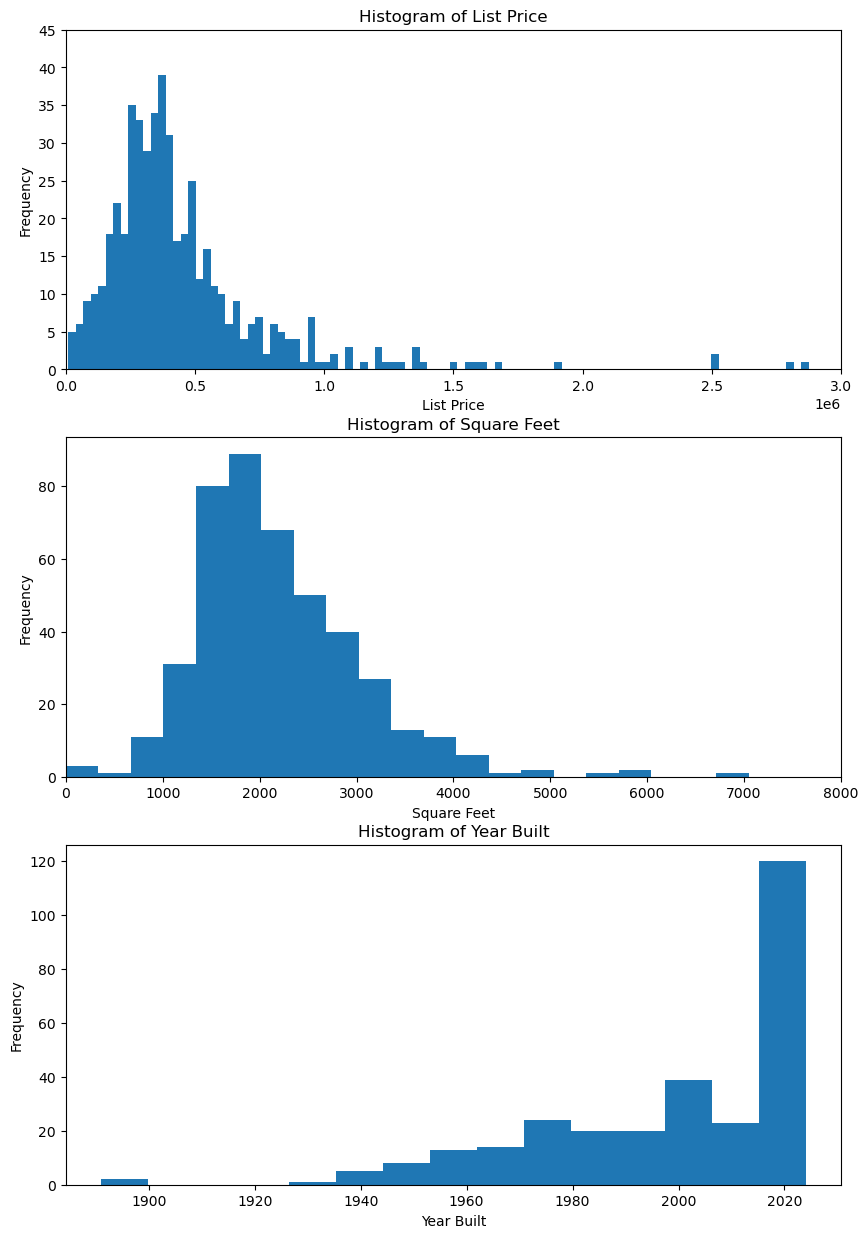

In [11]:
# Using subplots to create a figure to hold three plots.
# The plots are stacked vertically to properly display all information without the labels being blocked.

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Set up ax1 for the list price histogram.
ax1.hist(housing.listPrice, bins=1000)
ax1.set_title("Histogram of List Price")
ax1.set_xlabel("List Price")
ax1.set_ylabel("Frequency")
ax1.set_xlim(0,0.3e7)
ax1.set_ylim(0,45)

# Set up ax2 for the square footage histogram.
ax2.hist(housing.sqft, bins=200)
ax2.set_title("Histogram of Square Feet")
ax2.set_xlabel("Square Feet")
ax2.set_ylabel("Frequency")
ax2.set_xlim([0,8000])

# Set up ax3 for the year built histogram.
ax3.hist(housing.year_built, bins=15)
ax3.set_title("Histogram of Year Built")
ax3.set_xlabel("Year Built")
ax3.set_ylabel("Frequency")

plt.show()

Based on the histograms, we'd expect most homes to be between 400,000.00 and 500,000.00 us dollars,  to have about 2,000 sqft and to be built in 2020.

In [12]:
# To prepare the data for the bargraphs we need two variables to hold the x-values or
# The number of stories, types of homes, etc. The y variables or count will hold
# the total counts for each x variable.

types = housing.groupby('type').size().reset_index(name='Counts')['type']
type_count = housing.groupby('type').size().reset_index(name='Counts')['Counts']

stories = housing.groupby('stories').size().reset_index(name='Counts')['stories']
stories_count = housing.groupby('stories').size().reset_index(name='Counts')['Counts']

beds = housing.groupby('beds').size().reset_index(name='Counts')['beds']
beds_count = housing.groupby('beds').size().reset_index(name='Counts')['Counts']

baths = housing.groupby('baths').size().reset_index(name='Counts')['baths']
baths_count = housing.groupby('baths').size().reset_index(name='Counts')['Counts']

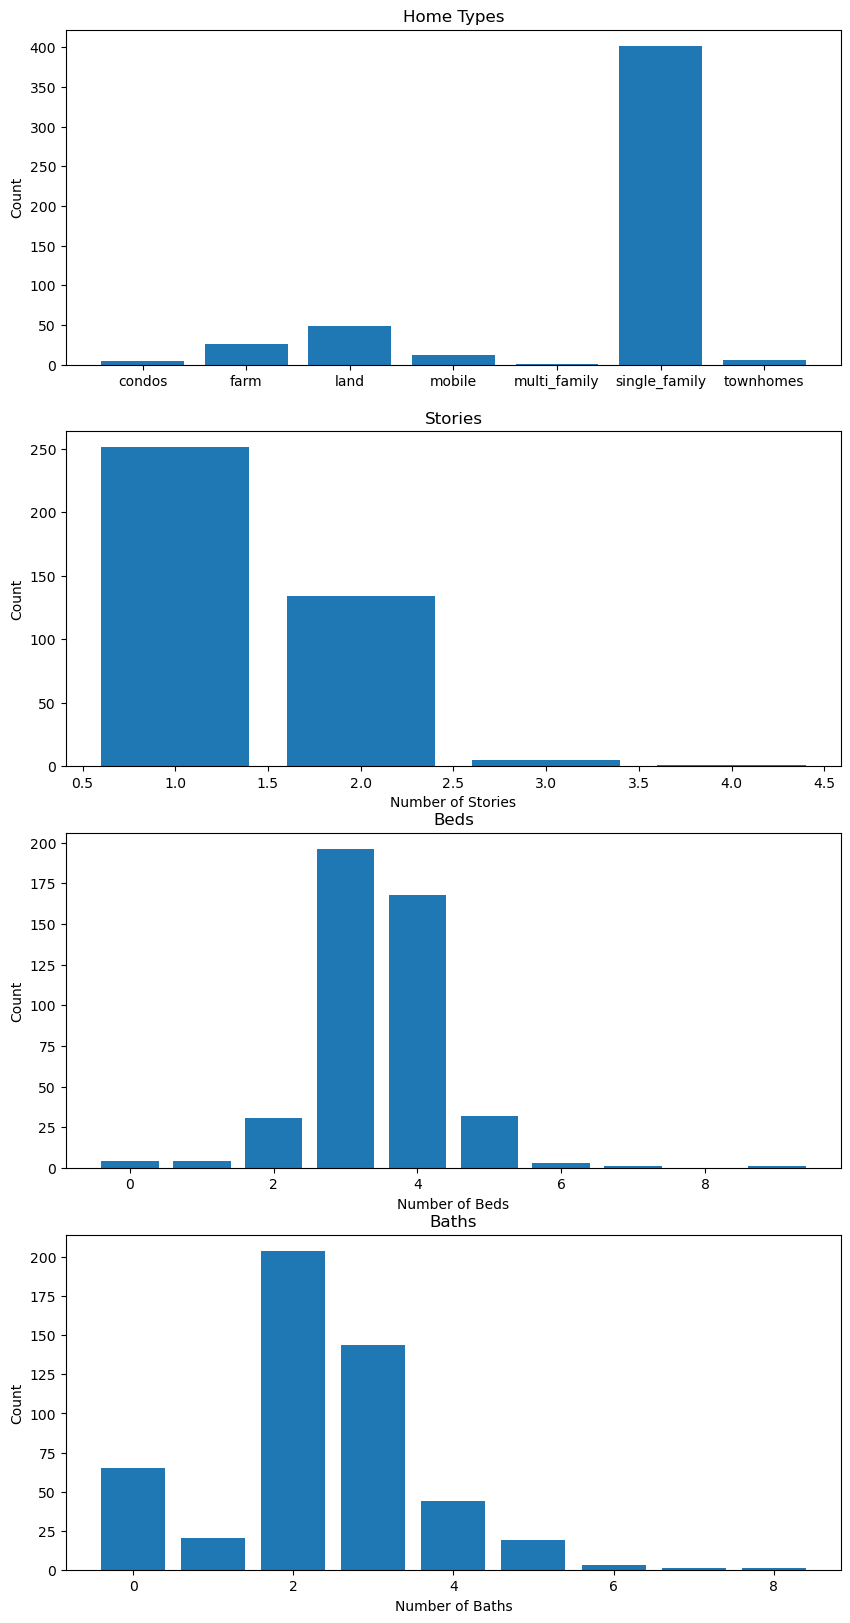

In [13]:
# Using subplots to create a figure to hold three plots.
# The plots are stacked vertically to properly display all information without the labels being blocked.
# This also makes the onformation easier for the user to read.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 20))

# Create the first bar chart for the home types.
ax1.bar(types, type_count)
ax1.set_title("Home Types")
ax1.set_ylabel("Count")

# Create the second bar chart for the number of stories.
ax2.bar(stories, stories_count)
ax2.set_title("Stories")
ax2.set_xlabel("Number of Stories")
ax2.set_ylabel("Count")

# Create the third bar chart for the number bedrooms.
ax3.bar(beds, beds_count)
ax3.set_title("Beds")
ax3.set_xlabel("Number of Beds")
ax3.set_ylabel("Count")

# Create the fourt bar chart for the number of baths.
ax4.bar(baths, baths_count)
ax4.set_title("Baths")
ax4.set_xlabel("Number of Baths")
ax4.set_ylabel("Count")

plt.show()

Most of the homes in the area will be 2 bedroom and 3 bathroom single story single family homes. 

With this informatioon we'd expect to see increases in home prices based on squarefootage, age and the number of bedrooms and bathrooms a home has.

In [14]:
# Create a new data frame without the columns containing text.

housingNoStrings = housing.drop(['url', 'id', 'status', 'sub_type', 'text', 'type'], axis=1)

In [15]:
# Create a correlation coefficient matrix of the data.

corr_matrix = housingNoStrings.corr()

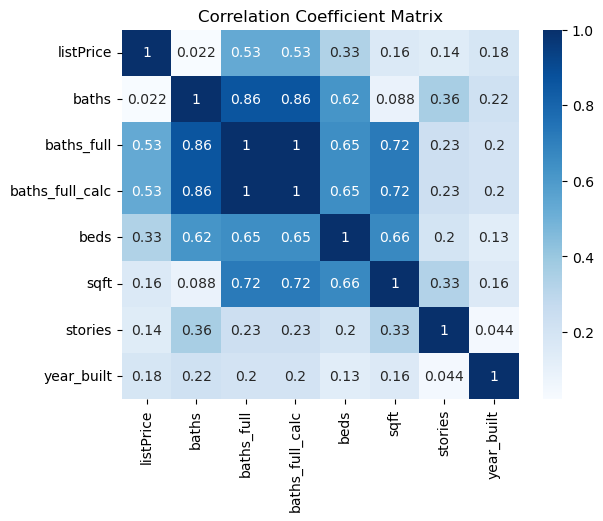

In [16]:
# Plot the correlation coefficient matrix.

sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Coefficient Matrix")
plt.show()

Based on the correlation coefficient matrix, the number of bathrooms has the weakest correlation with list price. This seems a but odd as the full bath counts have the strongest correlation with list prices. The next strongest correlation after these would be the number of beds. More exploration may be needed on the baths column. The mortgage company may value homes with square footage more as there's an opportunity to have more bathrooms in the house.

$\;\;\;\;\;\;$Based on the information obtained from the visualizations we should be able to model the using linear regression based on the homes attributes. Since the home descriptions were provided as well we can use this to see if the description has an effect on the listing price of the home as well. The biggest factors thus far that would seem to impact the value of the home prices are bathroom and bedroom counts. However, these appear to be correlated with square footage as well, but squarefootage doesn't seem to have much affect on the listing price. based on the other visualizations, the most common home in the data set should be a  2020, 2,000 square feet, 3 bed, 2 baths, single story, single family home selling for around $400,000. 

## Miletsone 2

### Dropping Features

in the data set there are a couple of columns that provide no value to the list price of the home. These columns would be the URL, status and ID. These can be safely dropped from the dataframe. 

In [17]:
# dropping the columns that provide no insight for the model.
housing = housing.drop(['url', 'status', 'id'], axis=1)
housing.head()

,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,sub_type,text,type,year_built
0,240000.0,2,2.0,2.0,3.0,1190.0,1.0,NaN,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,379900.0,4,3.0,3.0,4.0,2033.0,1.0,NaN,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,370000.0,2,2.0,2.0,4.0,2062.0,1.0,NaN,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,444000.0,4,3.0,3.0,5.0,3705.0,2.0,NaN,Come check out country living in the city! Are...,single_family,1985.0
4,569000.0,2,2.0,2.0,3.0,3282.0,2.0,NaN,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


We should also remove any column that has an excessive amount of NA values. For this we will consider any column to have more than 25% NA values excessive.

In [18]:
# The cutoff is 25% of the data in a column.
cutoff = len(housing)*.25

# A New dataframe is created with all features that comply with our restraint.
housing = housing.dropna(thresh = cutoff, axis=1)
housing.head()

,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,text,type,year_built
0,240000.0,2,2.0,2.0,3.0,1190.0,1.0,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,379900.0,4,3.0,3.0,4.0,2033.0,1.0,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,370000.0,2,2.0,2.0,4.0,2062.0,1.0,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,444000.0,4,3.0,3.0,5.0,3705.0,2.0,Come check out country living in the city! Are...,single_family,1985.0
4,569000.0,2,2.0,2.0,3.0,3282.0,2.0,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


There was only one column removed which was for subtype. This column seemed to be duplicated for the type column but with many missing values.

### Splitting the dataset

The text column may not help in the linear regression model. However, I don't intend on getting rid of them entirely. I will make a new text dataframe to hold these values. We can use this to model a bag of words matrix later on.

In [19]:
# Make a subset datafram for the text column.
textData = housing.loc[:, ['listPrice','text']]

# Remove the NA rows of text. We want the comments to be prefilled. 
textData = textData.dropna(subset=["text"])

# Outliers currently exist in the prices. We will only remove the missing listPrice rows.
# This will prevent the outliers from scewing the model.
textData =textData.dropna(subset = ["listPrice"])

Next we will drop the text data from our dataset.

In [20]:
# Drop the text column.
housing = housing.drop('text', axis=1)

### Dealing with the NA values.

In [21]:
housing.isna().sum()

listPrice            2
baths                0
baths_full          65
baths_full_calc     65
beds                61
sqft                63
stories            110
type                 0
year_built         212
dtype: int64

With regard to the NA values in the list price. These are causing erros when completing the Z-score for outliers. To prevent a scew of list price with these outliers we will need to remove these rows. The remaining NA values should be filled by using the mean of their respective columns.

In [22]:
# Drop the rows that contain an NA value in the list price.
housing = housing.dropna(subset = ["listPrice"])

In [23]:
# Replace missing values for square footage with the mean square footage.
housing.loc[pd.isnull(housing['sqft']), 'sqft'] = np.mean(housing['sqft'])

# Replace missing values for full baths with the mean full baths.
housing.loc[pd.isnull(housing['baths_full']), 'baths_full'] = np.mean(housing['baths_full'])

# Replace missing values for baths_full_calc with the mean baths_full_calc.
housing.loc[pd.isnull(housing['baths_full_calc']), 'baths_full_calc'] = np.mean(housing['baths_full_calc'])

# Replace missing values for beds with the mean beds.
housing.loc[pd.isnull(housing['beds']), 'beds'] = np.mean(housing['beds'])

# Replace missing values for stories with the mean stories.
housing.loc[pd.isnull(housing['stories']), 'stories'] = np.mean(housing['stories'])

# Replace missing values for year built with the mean year built.
housing.loc[pd.isnull(housing['year_built']), 'year_built'] = np.mean(housing['year_built'])

### Removing outliers

Now that the missing values for the list price are handled we can work on the outliers. Based on the graph below we have what appears to be a lot of outliers.

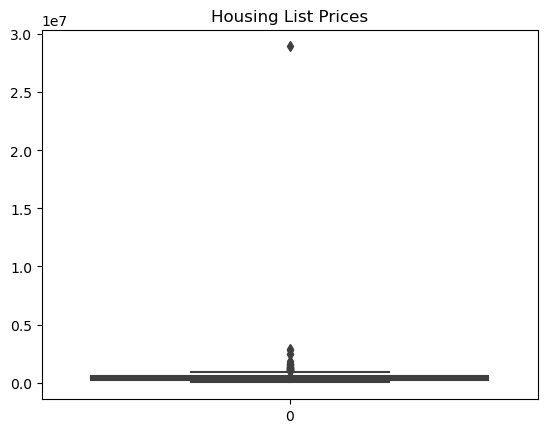

In [24]:
# Create a boxplot of the list values to show outliers.

sns.boxplot(housing['listPrice'])
plt.title("Housing List Prices")
plt.show()

First we will obtain the z-scores for the data.

In [25]:
z = np.abs(stats.zscore(housing['listPrice']))

Usually a z-score of 2 is used to remove outliers. However, above on the image below this data set has multiple outliers. The lowest I'm able to reduce the threshold is to one half.

In [26]:
# Set the z threshold to 0.5 
thresholdZ = .5

# Outliers in the data are any z score above this threshhold
outliers = np.where(z > thresholdZ)[0]

# Set a data frame to drop the outliers from the data.
newHousing = housing.drop(outliers)
print("Original DataFrame Shape:", housing.shape)
print("DataFrame Shape after Removing Outliers:", newHousing.shape)

Original DataFrame Shape: (499, 9)
DataFrame Shape after Removing Outliers: (478, 9)


This data may contain outliers still. as a precaution I will make a new data frame removing luxary homes. We will consider any home $1,000,000 or greater luxary.

In [27]:
# Making a data frame that has no luxary homes.
noLuxHomes = housing[housing['listPrice'] <= 1000000]

We should also make a no luxary homes data frame for the text data as well. Most prices above $1,000,000 appeared to be outliers in the data.

In [28]:
# Remove the homes over $1,000,000 from the text data frame. 
textData = textData[textData['listPrice'] <= 1000000]

### Create dummy variables

Next we will want to create dummy variables for categorical data in both the housing and no luxary homes data sets.

In [29]:
# Creating dummy variables over the data sets for any categorical columns.

newHousing = pd.get_dummies(newHousing, drop_first=True)
noLuxHomes = pd.get_dummies(noLuxHomes, drop_first=True)

### Prepping for modeling

Now that the data sets are cleaned we can prepare them for modeling. First we need to clean up the text data a little more.

#### Preparing the text data for custom modeling. 

The first step in this process is to remove the punctuation.

In [30]:
# Making a new column with the punctuation removed from the text data.

textData['cleaned'] = textData['text'].apply(lambda x: remove_punctuation(x))

Next, we want to tokenize the words, which will split the text into individual words.

In [31]:
# Make a new column to hold tokenized words.

textData['tokenized'] = textData['cleaned'].apply(lambda rev: word_tokenize(rev))

Now that the words have been tokenized we can remove the stop words from the nltk corpus.

In [32]:
# Set stop words to a variable. This allows it to used in apply.
stop_words = set(stopwords.words('english'))

# Make a new column with the stop words removed.
textData['no_stop'] = textData['tokenized'].apply(lambda x: remove_stop(x))

Now we want to apply port stemmer to the words. This will leave us with only the stem of the word.

In [33]:
# Set port stemmer to a variable.
porter = PorterStemmer()

# Make a new column applying the port stemmer to the previous column.
textData['stemmed'] = textData['no_stop'].apply(lambda x: stemmer(x))

The words have been stemmed but this left us with a list of words in the data frame. We will need to join them together and remove them from the list.

In [34]:
# use join to join the list of words in each row.
textData['stemmed'] = textData['stemmed'].apply(lambda x: ' '.join(map(str, x)))
textData.head()

,listPrice,text,cleaned,tokenized,no_stop,stemmed
0,240000.0,Welcome home to your peaceful retreat nestled ...,Welcome home to your peaceful retreat nestled ...,"[Welcome, home, to, your, peaceful, retreat, n...","[Welcome, home, peaceful, retreat, nestled, 2,...",welcom home peac retreat nestl 2 acr beauti la...
1,379900.0,"Beautiful country home on 0.85 fenced acres, m...",Beautiful country home on 085 fenced acres min...,"[Beautiful, country, home, on, 085, fenced, ac...","[Beautiful, country, home, 085, fenced, acres,...",beauti countri home 085 fenc acr minut athen a...
2,370000.0,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,"[PRICED, TO, SELL, CORNER, LOT, HAS, A, STORM,...","[PRICED, TO, SELL, CORNER, LOT, HAS, A, STORM,...",price to sell corner lot ha a storm shelter in...
3,444000.0,Come check out country living in the city! Are...,Come check out country living in the city Are ...,"[Come, check, out, country, living, in, the, c...","[Come, check, country, living, city, Are, look...",come check countri live citi are look larg fam...
4,569000.0,Welcome to your dream retreat! Nestled on over...,Welcome to your dream retreat Nestled on over ...,"[Welcome, to, your, dream, retreat, Nestled, o...","[Welcome, dream, retreat, Nestled, 7, acres, s...",welcom dream retreat nestl 7 acr seclud land a...


The text data is now ready for use in a custom model. However, we will only keep the final stemmed column and the home values.

In [35]:
# Remove all columns but the listPrice and the stemmed columns.
textData = textData.drop(['text', 'cleaned', 'tokenized', 'no_stop'], axis=1)
textData.head()

,listPrice,stemmed
0,240000.0,welcom home peac retreat nestl 2 acr beauti la...
1,379900.0,beauti countri home 085 fenc acr minut athen a...
2,370000.0,price to sell corner lot ha a storm shelter in...
3,444000.0,come check countri live citi are look larg fam...
4,569000.0,welcom dream retreat nestl 7 acr seclud land a...


#### feature selection on housing data

From here we will split the data into testing and training sets. 

In [36]:
# The target values are the sales price.
target = 'listPrice'

# The features are the remaining columns minus the sales price.
features = newHousing.drop(target, axis=1)

#Split the data into testing anf training sets.
X_train, X_test, y_train, y_test = train_test_split(features, newHousing[target], test_size=0.2, random_state=11)


In [37]:
# The target values are the sales price.
target = 'listPrice'

# The features are the remaining columns minus the sales price.
features = noLuxHomes.drop(target, axis=1)

#Split the data into testing anf training sets.
X_train_noLux, X_test_noLux, y_train_noLux, y_test_noLux = train_test_split(features, 
                                                                            noLuxHomes[target], 
                                                                            test_size=0.2, 
                                                                           random_state=11)

The data has now been cleaned, outliers removed and is ready for the modeling process.

## Miletsone 3: Modeling

For the first step in this process I'll be using a linear regression model. I chose this model since one or more variables could affect the cost of a home. This typ of model also is more suitable for predicting futrue prices.

Step 1: We need to mke the linear regression model and fit this training data to it.

In [38]:
# Assign the linear regression function to a variable.
linear_model = LinearRegression()

# fit the training data to the model.
linear_model.fit(X_train, y_train)

LinearRegression()

Step 2: Find the predicted home values of the model using the hold out features in X_test

In [39]:
# Obtain the predictions from the model using X_test.
testpred = linear_model.predict(X_test)

Step3: Check the sccuracy of the model using the RMSE and r2

RMSE and R2 were chosen as I couldn't use the accuracy function on the model since this can't be used on the regression model.

In [40]:
# Calculate the r2 and RMSE of the model since this is linear regression.
r2 = r2_score(y_test, testpred)
rmse = np.sqrt(mean_squared_error(y_test, testpred))

In [41]:
print(f"The r2 value of this model is {r2}")

The r2 value of this model is 0.13326751426889993


In [42]:
print(f"The rmse of this model is {rmse}")

The rmse of this model is 288495.83191231644


The RMSE value on the the model using all the housing data is quie high and the the r2 value is low. This would mean that the model doesn't model the data very well. This could be due to additional outliers in the data. We should check the no luxary home data next to see if removing luxary homes helps the model. We will follow the same steps as we did here.

### No luxary homes model

In [43]:
# Make a new linear regression model wit the no luxary home data to prevent data leakage.
linear_model = LinearRegression()
linear_model.fit(X_train_noLux, y_train_noLux)

LinearRegression()

In [44]:
# Obtain the prediction from the new model.
pred = linear_model.predict(X_test_noLux)

In [45]:
#Calculate the r2 and rmse
r2 = r2_score(y_test_noLux, pred)
rmse = np.sqrt(mean_squared_error(y_test_noLux, pred))

In [46]:
print(f"The r2 value of this model is {r2}")

The r2 value of this model is 0.34671056262231625


In [47]:
print(f"The rmse of this model is {rmse}")

The rmse of this model is 150981.15377851113


The model has improved when we removed the homes over $1,000,000.00. The improvement is quite significant but the RMSE and r2 values aren't great. We want the RMSE closer to zero and the r2 closer to one for a better fit. Reviewing the data set we left in land, multifamily homes and so one. Lets make one more model using only the single family homes and repeat the previous steps.

### Making adjustments to the data

In [48]:
noLuxHomes.head()

,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,year_built,type_farm,type_land,type_mobile,type_multi_family,type_single_family,type_townhomes
0,240000.0,2,2.0,2.0,3.0,1190.0,1.0,2018.0,False,False,False,False,True,False
1,379900.0,4,3.0,3.0,4.0,2033.0,1.0,2002.0,False,False,False,False,True,False
2,370000.0,2,2.0,2.0,4.0,2062.0,1.0,2012.0,False,False,False,False,True,False
3,444000.0,4,3.0,3.0,5.0,3705.0,2.0,1985.0,False,False,False,False,True,False
4,569000.0,2,2.0,2.0,3.0,3282.0,2.0,1981.0,False,False,False,False,True,False


In [49]:
# Take only the single familiy homes as the data.
noLuxHomesSFH = noLuxHomes[noLuxHomes["type_single_family"] == True]

In [50]:
# The target values are the list price.
target = 'listPrice'

# The features are the remaining columns minus the list price.
features = noLuxHomesSFH.drop(target, axis=1)

#Split the data into testing and training sets.
X_train1, X_test1, y_train1, y_test1 = train_test_split(features, 
                                                    noLuxHomesSFH[target], 
                                                    test_size=0.2, 
                                                    random_state=11)

In [51]:
# Setting the linear regression function to a new variable.
linear_modelSFH = LinearRegression()

# Fit the new training data to the linear regression model.
linear_modelSFH.fit(X_train1, y_train1)

LinearRegression()

In [52]:
# Obtain the new predictions of the model.
testpred = linear_modelSFH.predict(X_test1)

In [53]:
# Calculate the r2 and RMSE of the model.

r2 = r2_score(y_test1, testpred)
rmse = np.sqrt(mean_squared_error(y_test1, testpred))

In [54]:
print(f"The r2 value of this model is {r2}")

The r2 value of this model is 0.40563429684737307


In [55]:
print(f"The rmse of this model is {rmse}")

The rmse of this model is 145131.38839224481


In [56]:
# Check for over and under fitting.
fit = linear_modelSFH.score(X_test, y_test)*100
print(f"The model fits the features and the targets of the training data at {fit}%")

The model fits the features and the targets of the training data at 20.27302564486505%


Using only the single family home data the r2 value is looking better but RMSE is still high. This model also has another issue that it's underfitting the data. Using the model score we see that only 20% of the training data gets modeled to the training list price data. Maybe linear regression isn't the best model for this data. We will need to chack a couple other linear models.

### Best model selection

Step 1: We need a scaler. I chose the power transformer because the data appears to be heteroscedastic. We will also need to create a pipeline variable using our original linear regression model.

In [57]:
# Assign the robust scaler function to a variable.
robusts = PowerTransformer()

# Assign the linear regression function to a variable.
lin_regress = LinearRegression()

#Create a pipeline with the scalar and the classifier.
pipeline = Pipeline([("scaler", robusts), ("classifier", lin_regress)])

Step 2: We will need to fit the training data to the new model.

In [58]:
# Fit the training data to the pipeline.
pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('classifier', LinearRegression())])

Step 3: Obtain the predicted values of the new linear regression model.

In [59]:
# Obtain the prediction of the pipeline.
prediction = pipeline.predict(X_test1)

Step 4: Obtain the RMSE and R2 of the model.

In [60]:
# Obtain the r2 and RMSE scores of the model.

r2 = r2_score(y_test1, prediction)
rmse = np.sqrt(mean_squared_error(y_test1, prediction))

In [61]:
print(f"The r2 value of this model is {r2}")

The r2 value of this model is 0.43418867691501173


In [62]:
print(f"The rmse of this model is {rmse}")

The rmse of this model is 141602.29640482573


We can already see that adding a scaler has made an improvement to the model. Next we will need to see if there is a better linear model.

Step 4: Creat a search space using the different types of models to check. We will also need to do a 5 crossfold validation to check for over and underfitting and then fit the data to the best model.

The 2 modles I chose were SVM and Linear Random Forrest. These two seemed like the best candidates for an alternate linear regression.

In [63]:
# Create a search space with linear regression and linear random forrest and SVM.
searchspace = [{"classifier": [LinearRegression()]},
              {'classifier': [RandomForestRegressor()]},
              {'classifier': [svm.LinearSVC()]}]

# Grid search over the new search space with the 5-fold cross validation.
grids = GridSearchCV(pipeline, searchspace, cv = 5)

# Fit the training data to the best model.
bestModel = grids.fit(X_train, y_train)

Step 5: Print out what the best model is for the data.

In [64]:
print(bestModel.best_estimator_)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('classifier', RandomForestRegressor())])


Step 6: Fit the test data to the new model, obtain the prediction and check it for accuracy.

In [65]:
# Fit the test data to the model.
bestModel.fit(X_test1, y_test1)

# Obtain the prediction from the best model on X_test.
prediction = bestModel.predict(X_test1)

# Onbtain the r2 and RMSE of the best model
r2 = r2_score(y_test1, prediction)
rmse = np.sqrt(mean_squared_error(y_test1, prediction))

In [66]:
print(f"The r2 value of this model is {r2}")

The r2 value of this model is 0.5113103718327658


In [67]:
print(f"The rmse of this model is {rmse}")

The rmse of this model is 131598.5306362607


In [68]:
best_fit = bestModel.score(X_test1, y_test1)
print(f"The best model fits the features and the targets of the training data at {best_fit}%")

The best model fits the features and the targets of the training data at 0.5113103718327658%


The Random forrest provide the best model thus far for the data. the R2 is closer to 1 but it's still pretty far off. The RMSE is still to hight for the model. We also see that the model is fitting the data better but is still slightly underfitted. This could be due to additional outliers in the data or missing features that would help predict home values. We're unable to split the data by zipcode. Zipcodes are an important feature in housing data, as they can be used to search for crime in an area or school scores. Both would have a massive impact on the value of a home.